In [138]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import supervision as sv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [177]:
model_name = "IDEA-Research/grounding-dino-tiny"

processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_name).to(device)

In [ ]:
# img = Image.open("../data/dummy_selfie.png")
# txt_prompt = "blonde hair . face ."

img = Image.open("../data/dummy_cats.png")
txt_prompt = "orange cat . black cat . gray cat . white cat ."

# prompt engineering: . separator
#   blonde hair face   : Tries to match all three words at once
#   blonde hair . face : triggers sub sentence grounding, it tries to find sentence 1 OR sentence 2 OR ... OR sentence n
#   Put . at the end of everyword, this triggers the sub sentence, indicates sentence is complete for the model
#   Put contrasty classes so the zero shot model can have something to refer to, for example white cat, black cat, even if you care about white cats,
#     if the model found a black cat, it will match teh word cat highly passing the threshold, even if it doesn't match one word (white) so solution is
#     put (black cat) as a counter class to suck in that prediction
#   Note the model returns the largest box that meets everything, ex blonde hair face, will return the biggest box that contains those
#   * carefull dont' leave a space after the dot as this triggers another subsentence



inputs = processor(images=img, text=txt_prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(**inputs)

In [272]:
print(list(inputs.keys()))
# pixel_values  :  the image itself scaled and normalized
# pixel_mask    :  same as attention_mask, used to mask out the padding pixels  
# input_ids     :  the tokenized txt to feed the BERT model
# token_type_ids:  legacy thingy for processors to have, to tell the index of the sentence something belongs to, since we give 1 sentence this is always 1
# attention_mask:  attention_mask to mask out special tokens like <end of sentence> and such stuff

['pixel_values', 'pixel_mask', 'input_ids', 'token_type_ids', 'attention_mask']


In [273]:
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.45,         # The threshold itself for the boundary box confidence
    text_threshold=0.3,     # Threshold for the boundary box matching a token in the text input
    target_sizes=[img.size[::-1]]
)

results

[{'scores': tensor([0.7425, 0.5657]),
  'boxes': tensor([[1525.6694,  438.2952, 1878.1700, 1081.9064],
          [ 905.6720,  416.4782, 1241.7922, 1101.2113]]),
  'text_labels': ['orange cat', 'white cat'],
  'labels': ['orange cat', 'white cat']}]

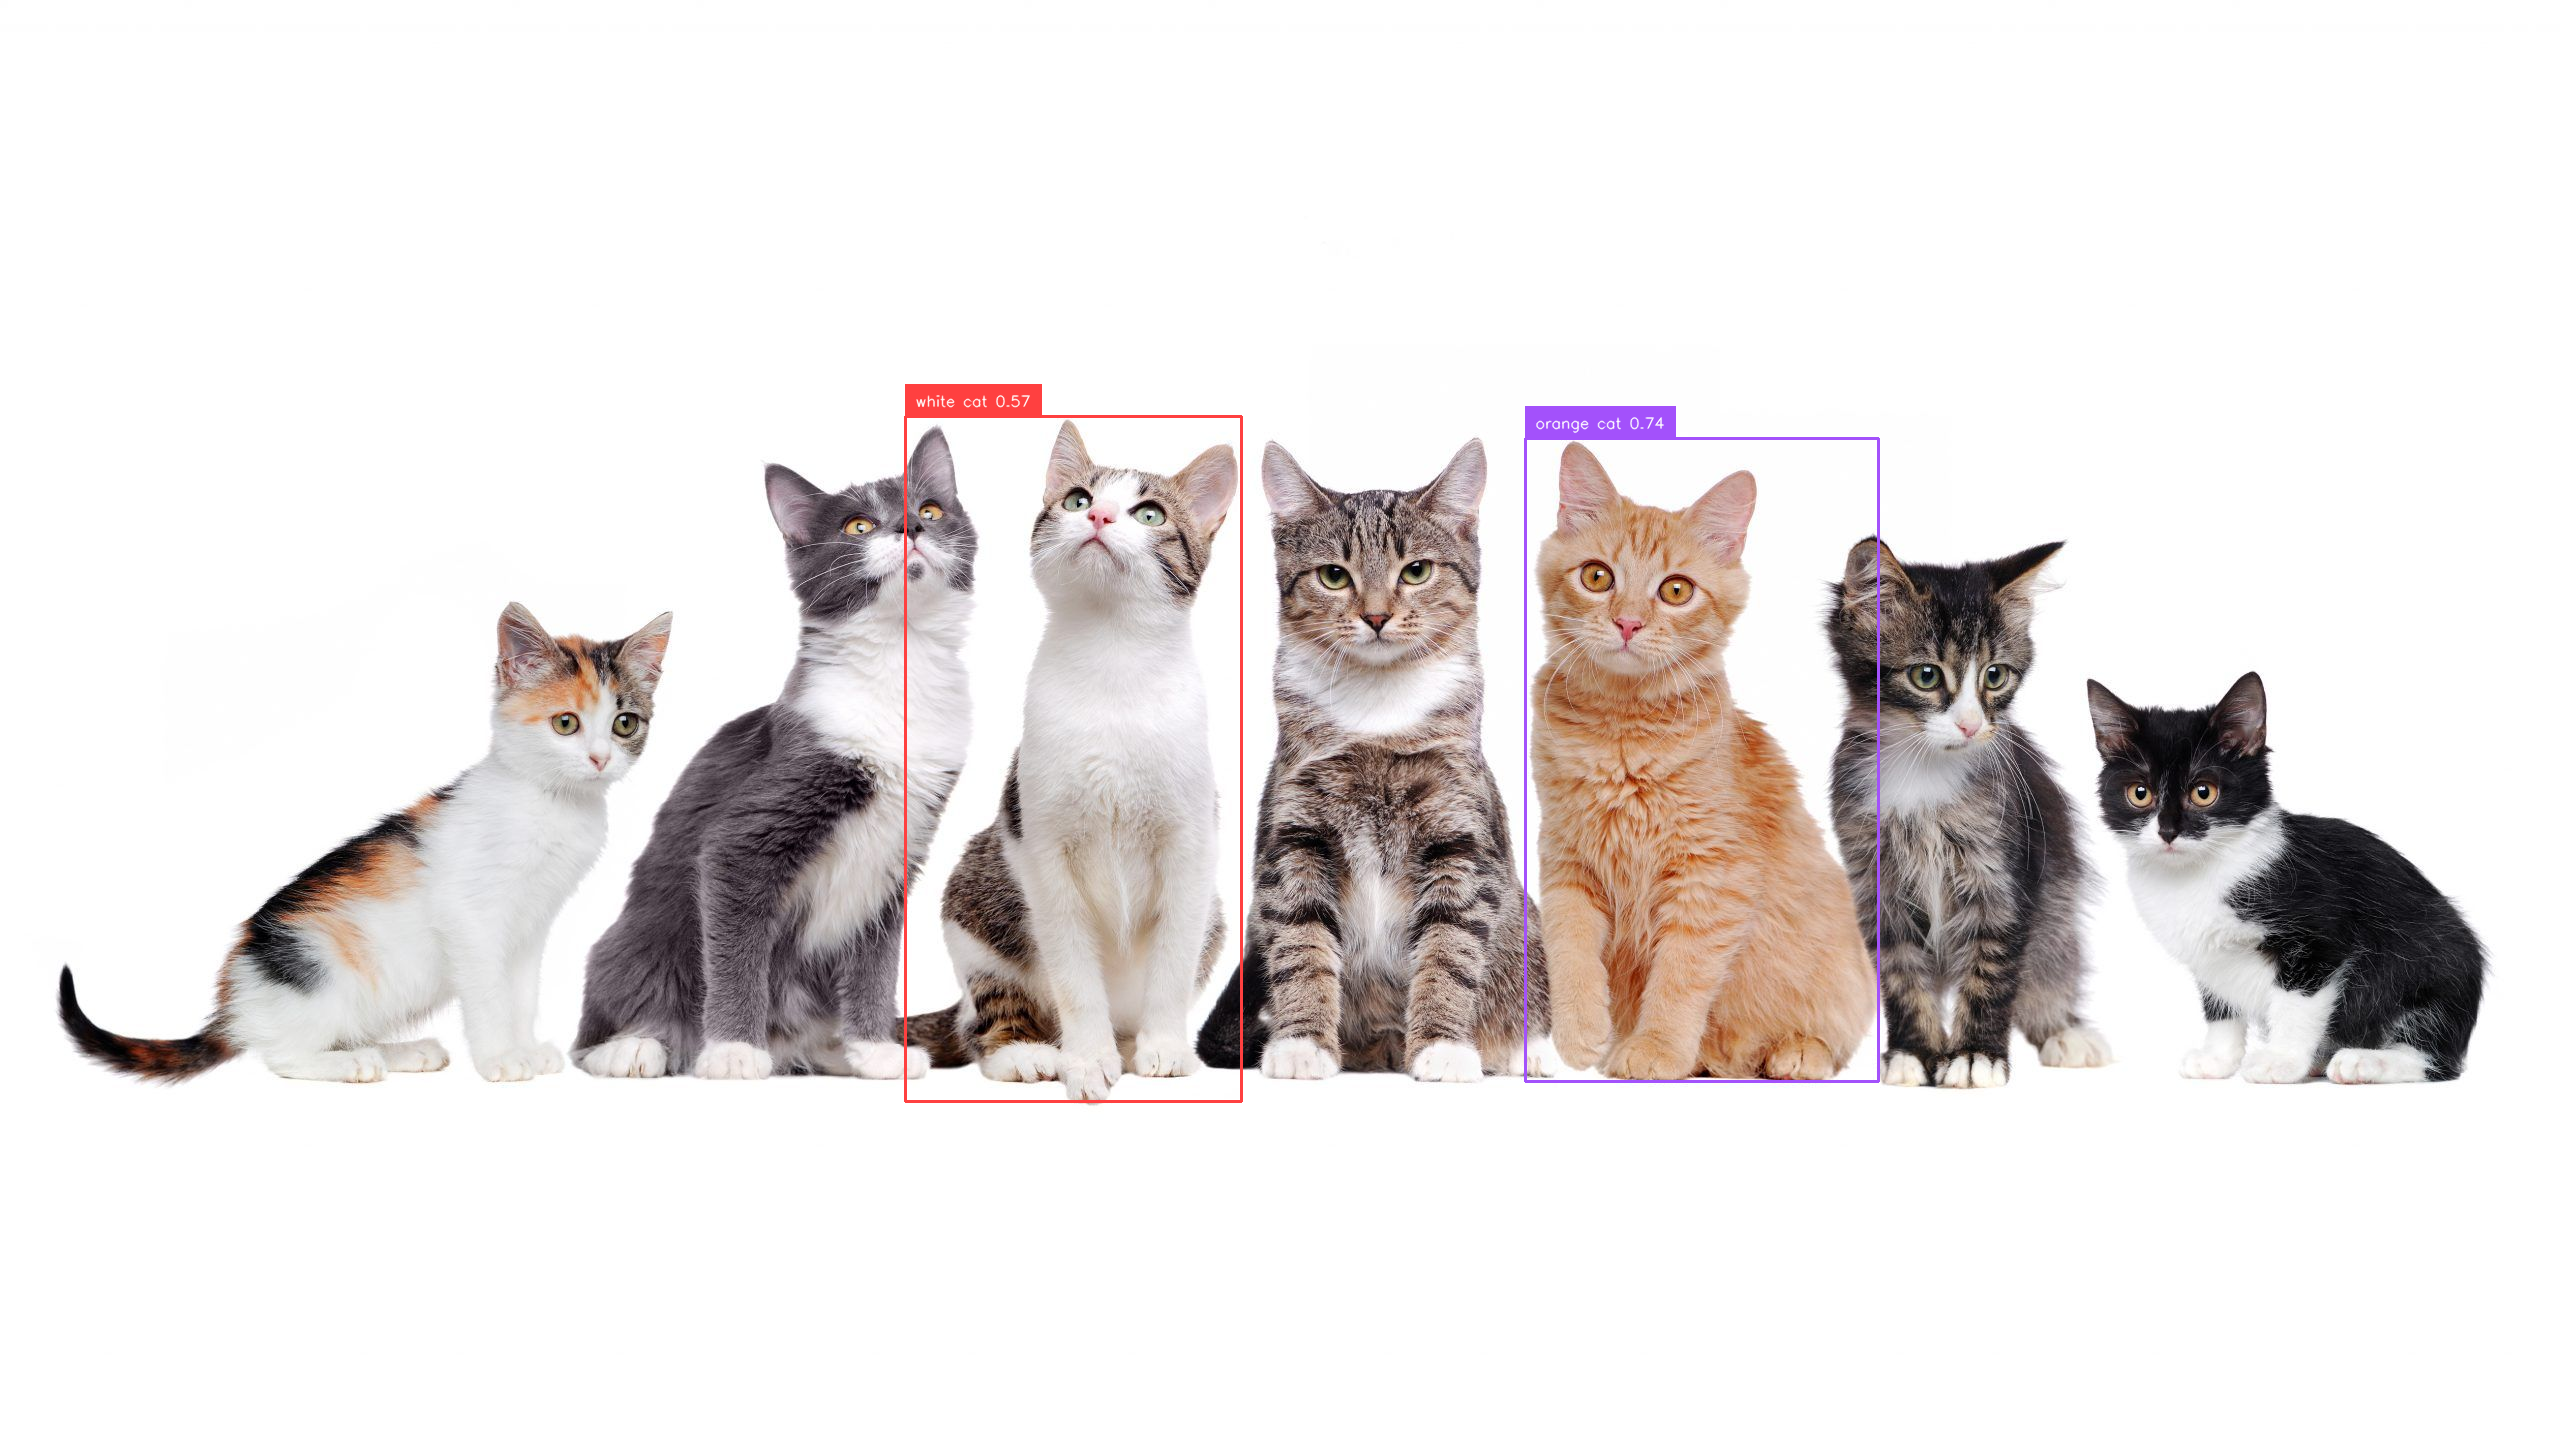

In [274]:
result = results[0]
detections = sv.Detections(
    xyxy=result['boxes'].cpu().numpy(),
    confidence=result['scores'].cpu().numpy(),
    class_id=np.arange(len(result['text_labels'])),
)

labels = [f"{result['text_labels'][i]} {result['scores'][i]:.2f}" for i in range(len(result['text_labels']))]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

annotated_frame